In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots

In [2]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from matplotlib.gridspec import GridSpec
from collections import defaultdict
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, LeaveOneOut, KFold
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, confusion_matrix
from sklearn.neighbors import KNeighborsRegressor

In [3]:
format_plots()
#format_pizza_plots()
c = PlotConfig()

In [4]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#dadaeb','#6a51a3']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

In [5]:
def _plot_cm(y_true, y_pred, ax, ax_labels, title):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm / cm.sum(axis=1, keepdims=True)
    im = ax.imshow(cm, cmap='cubehelix', vmin=0, vmax=1)
    plt.xticks(range(len(ax_labels)), ax_labels)
    plt.yticks(range(len(ax_labels)), ax_labels)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Real')
    ax.set_title(title)
    return im

def plot_cm(y_true, y_pred, y_shuffle_true, y_shuffle_pred):
    '''
    plot confusion matrix

    Args:
        y_true ([np.array]): array for true label
        y_pred ([np.array]): array for predicted label
        y_shuffle_true ([np.array]): array for shffuled label
        y_shuffle_pred ([np.array]): array for shuffled predicted label
    '''
    fig = plt.figure(figsize=(23, 10), facecolor='white')
    gs = GridSpec(ncols=3, nrows=1, wspace=0.1, figure = fig, width_ratios=[10,10,0.3])
    fig_ax = fig.add_subplot(gs[0,0])
    labels = np.unique(y_true)
    _plot_cm(y_true, y_pred, fig_ax, labels, f'Real Accuracy {accuracy_score(y_true, y_pred):0.2f}')

    fig_ax = fig.add_subplot(gs[0,1])
    im = _plot_cm(y_shuffle_true, y_shuffle_pred, fig_ax, labels, f'Shuffle Accuracy {accuracy_score(y_shuffle_true, y_shuffle_pred):0.2f}')
    fig_ax.set_ylabel('')
    fig_ax.set_yticklabels([])

    # plot colorbar
    cb = fig.add_subplot(gs[0,2])
    fig.colorbar(mappable=im, cax=cb, label='Fraction of labels', )
    fig.tight_layout()
    plt.show()
    c = PlotConfig()
    fig.savefig(c.dana_save_path / "age_vs_behavioral_age"/ 'age_decoder_confusion_pre.pdf')

In [6]:
# get data
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_relabeled_usage_matrix_v00.parquet')
#path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_relabeled_counts_matrix_v00.parquet')
df = pd.read_parquet(path)

In [7]:
## update data
def filter_df(df):
    max=100
    #df.drop('9c060c9b-9eee-4788-90be-803700bbacd8',level=3, axis=0, inplace=True)
    syll=df.columns.values[df.columns.values>max]
    df.drop(syll,axis=1, inplace=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

In [8]:
# choose a model for decoder
clf = KNeighborsRegressor(n_neighbors=10)
#clf = svm.SVC(kernel='linear') 
#clf = RandomForestClassifier(n_estimators = 100)
#clf = LinearRegression()
# choose cross validation scheme
cv = LeaveOneOut()

#number of iterations for shuffle
it=100

In [9]:
# process data

In [10]:
#prepare data
data = df.astype(float, errors='ignore')
data= filter_df(data).groupby(['age','uuid']).mean()
ages = data.index.get_level_values('age')
mice = data.index.get_level_values('uuid')

y_age =data.index.get_level_values('age').to_numpy()
X=data.to_numpy()
#X=np.log(X + 1e-6) # convert to linear

In [11]:
#decoder
y_pred = cross_val_predict(clf, X, y_age, cv=cv)
r2_age = r2_score(y_age, y_pred)
print(r2_age)

0.6664596644690538


In [12]:
#shuffle
ysh_score_age=[]
ysh_age=[]
ysh_predict_age=[]
ysh_mse_age=[]
for i in tqdm(range(it)):
    ysh_temp=np.random.permutation(y_age)
    y_pred_temp = cross_val_predict(clf, X, ysh_temp, cv=cv)
    ysh_score_age.append(r2_score(y_age, y_pred_temp))
    ysh_age.extend(ysh_temp)
    ysh_predict_age.extend(y_pred_temp)
    ysh_mse_age.append(mean_squared_error(y_age, y_pred_temp))


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.12it/s]


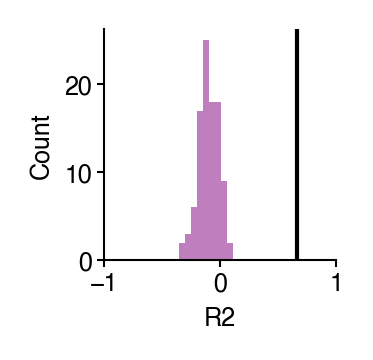

In [13]:
fig = plt.figure(figsize=(1, 1))
fig.dpi = 300
ax = sns.histplot(data=ysh_score_age, fill=True, element='step', lw=0, color='purple', alpha=0.5)
ax.axvline(r2_age, color='black', lw=1)
#plt.xticks(ticks=[])
ax.set(ylabel='Count')
ax.set(xlabel='R2')
plt.xlim([-1,1])
sns.despine()
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'age_regression_performance.pdf', bbox_inches='tight')

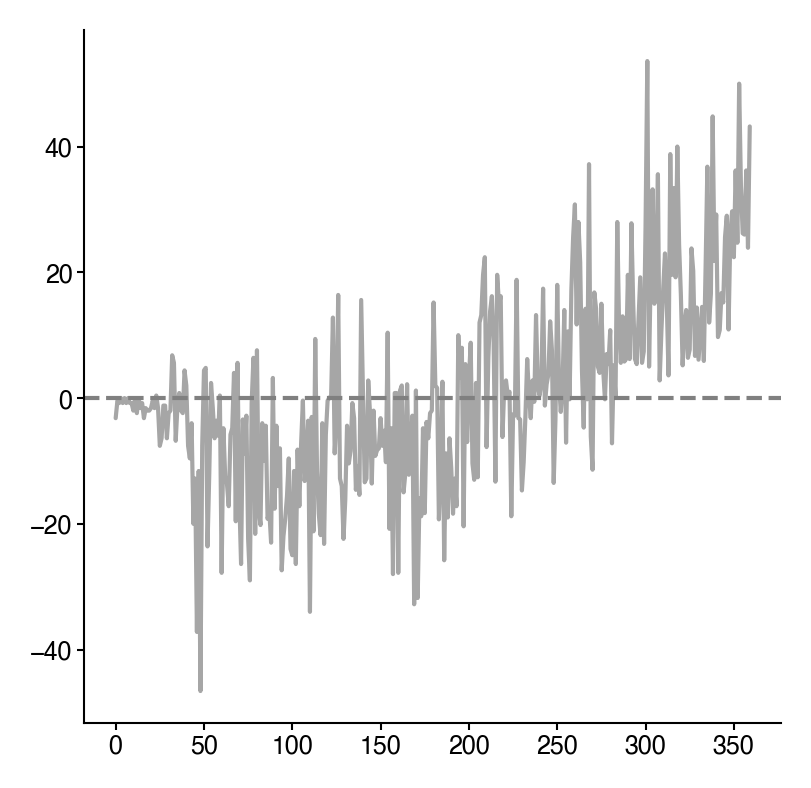

In [14]:
# plot residuals
#X=np.log(X + 1e-6) # convert to linear
fig, ax = plt.subplots()
res_age = y_age-y_pred
fig.dpi = 300
plt.plot (res_age, color='grey', lw=1, alpha=0.7)
#plt.ylim([-20, 5])
ax.axhline(y=0, color='gray', linestyle='--')
sns.despine()
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'e_age_decoder_residues.pdf', bbox_inches='tight')

In [15]:
# decoder with real vs predicted by age
decoder=pd.DataFrame()
decoder['age'] = y_age
decoder['pred'] = y_pred

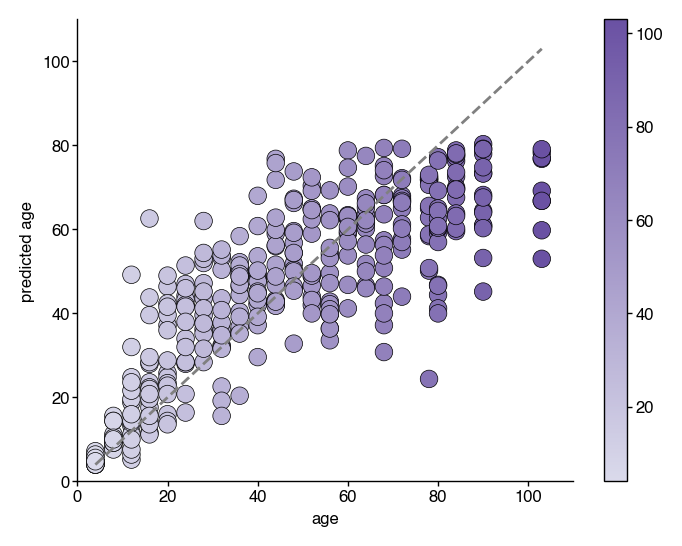

In [16]:
fig, ax = plt.subplots()
fig.set_size_inches(4,3) 
plt.scatter(x=y_age, y=y_pred, 
            s=40, 
            c=y_age, 
            edgecolor='black',
            linewidth=0.25,
            #norm='log',
            cmap=cmm)
sns.despine()
norm = plt.Normalize(y_age.min(), y_age.max())
sm = plt.cm.ScalarMappable(cmap=cmm, norm=norm)
sm.set_array([])
plt.ylim([0, 110])
plt.xlim([0, 110])
plt.xlabel('age')
plt.ylabel('predicted age')
plt.plot(y_age, y_age, linestyle='--', color='gray')
# Remove the legend and add a colorbar
ax.figure.colorbar(sm)
c = PlotConfig()
plt.savefig(c.dana_save_path / "fig3"/ 'd_decoder_age_vs_predicted_by_session.pdf', bbox_inches='tight')